In [5]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [6]:
img_list=[]
files = os.listdir("C:/Users/pc/Desktop/DiaRet/step1/train_images")
for i in files[::]:
    image = cv2.imread(f"C:/Users/pc/Desktop/DiaRet/step1/train_images/{i}")
    image = cv2.resize(image,(400,400))
    image = image[:,:,1]
    kopya = image.copy()
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thold = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kenar = cv2.findContours(thold.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kenar = kenar[0][0]
    kenar = kenar[:,0,:]
    x1 = tuple(kenar[kenar[:,0].argmin()])[0]
    y1 = tuple(kenar[kenar[:,1].argmin()])[1]
    x2 = tuple(kenar[kenar[:,0].argmax()])[0]
    y2 = tuple(kenar[kenar[:,1].argmin()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*4//50
    kopya2 = image.copy()
    if x2-x1 > 100 and y2-y1 > 100:
        kopya2 = kopya2[y1+y:y2-y,x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    clahe = cv2.createCLAHE(clipLimit = 5.0,tileGridSize=((8,8)))
    cl = clahe.apply(kopya2)
    med_resim = cv2.medianBlur(kopya2,3)
    arka_plan = cv2.medianBlur(kopya2,33)
    maske = cv2.addWeighted(med_resim,1,arka_plan,-1,255)
    maske_resim = cv2.bitwise_and(maske,med_resim)
    img_list.append(maske_resim)
    

In [7]:
df = pd.read_csv("C:/Users/pc/Desktop/DiaRet/step1/train.csv")
y_train = pd.get_dummies(df["diagnosis"]).values.astype(int)
x_train = np.array(img_list)

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.15,random_state=42,shuffle = True)

In [9]:
y_train_binary = np.argmax(y_train, axis=1)  
y_test_binary = np.argmax(y_test, axis=1)

In [10]:
import numpy as np

x_train = np.repeat(np.expand_dims(x_train, axis=-1), 3, axis=-1)
x_test = np.repeat(np.expand_dims(x_test, axis=-1), 3, axis=-1)

print(x_train.shape) 
print(x_test.shape)  

(3112, 400, 400, 3)
(550, 400, 400, 3)


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications.efficientnet import preprocess_input

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

inputs = tf.keras.Input(shape=(400, 400, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x) 
outputs = layers.Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=AdamW(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=16)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = valid_datagen.flow(x_test, y_test, batch_size=16)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

C:\Users\pc\conda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.8204 - loss: 0.4561 - val_accuracy: 0.9455 - val_loss: 0.2291
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.9259 - loss: 0.2147 - val_accuracy: 0.9491 - val_loss: 0.1192
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.9287 - loss: 0.2205 - val_accuracy: 0.9600 - val_loss: 0.1014
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 552s 3s/step - accuracy: 0.9401 - loss: 0.1739 - val_accuracy: 0.9691 - val_loss: 0.0871
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 537s 3s/step - accuracy: 0.9442 - loss: 0.1560 - val_accuracy: 0.9545 - val_loss: 0.1055
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.9516 - loss: 0.1431 - val_accuracy: 0.9382 - val_loss: 0.1806
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 537s 3s/step - accuracy: 0.9504 - loss: 0.1554 - val_accuracy: 0.9673 - val_loss: 0.0992
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.9542 - loss: 0.1403 - val_accu

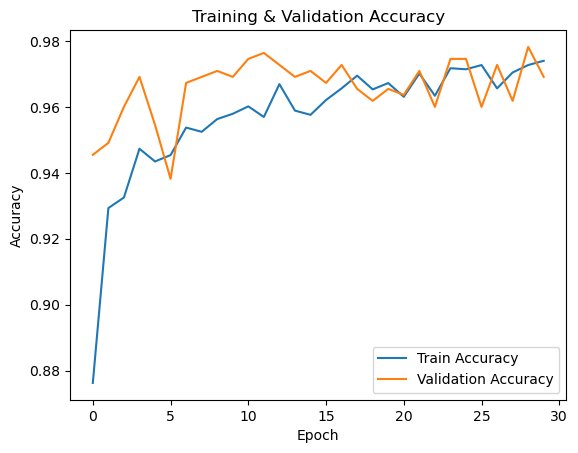

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

In [15]:

import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef

y_pred_probs = model.predict(x_test) 
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = np.argmax(y_test, axis=1) 

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# TN, FP, FN, TP 
if cm.shape == (2,2):
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
else:
    specificity = "Only for binary classification"

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Sensitivity (Recall)
sensitivity = recall_score(y_true, y_pred, average='macro')

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity}")
print(f"MCC: {mcc:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step
Confusion Matrix:
[[255   8]
 [  9 278]]
Accuracy: 0.9691
Sensitivity (Recall): 0.9691
Specificity: 0.9695817490494296
MCC: 0.9381


In [17]:
import keras
keras.saving.save_model(model, 'C:/Users/pc/Desktop/DiaRet/step/step1.keras')
